In [1]:
import fitz
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from doctr.models import ocr_predictor
from doctr.io import DocumentFile
from PIL import Image
import torch
from transformers import VisionEncoderDecoderModel, TrOCRProcessor,BitsAndBytesConfig
from pdf2image import convert_from_path
from langchain_huggingface import HuggingFaceEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sklearn.preprocessing import StandardScaler
import torch
import json
import csv
import threading
import requests
# import response
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500,
        chunk_overlap=0
    )

In [2]:
def classify_and_extract_pdf(pdf_path, text_threshold=20):
    doc = fitz.open(pdf_path)
    image_pages = 0
    text_pages = 0
    full_text = ""

    for page_num in range(len(doc)):
        page = doc[page_num]
        text = page.get_text()
        images = page.get_images(full=True)

        if len(text.strip()) < text_threshold and len(images) > 0:
            image_pages += 1
        else:
            text_pages += 1
            full_text += f"\n--- Page {page_num + 1} ---\n{text}"

    doc.close()

    if image_pages > text_pages:
        return 0
    else:
        return full_text.strip()

In [3]:
def preprocess_image(pil_image):
    """Convert a PIL image to grayscale and apply adaptive thresholding."""
    img = np.array(pil_image)  
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 10)
    return Image.fromarray(binary).convert("RGB")  
def cluster_lines(boxes, y_threshold=15):
    """Groups bounding boxes into lines and sorts them correctly."""
    boxes = sorted(boxes, key=lambda b: b[1])
    lines = []
    current_line = []
    for box in boxes:
        if not current_line:
            current_line.append(box)
        else:
            prev_box = current_line[-1]
            if abs(box[1] - prev_box[1]) < y_threshold:  
                current_line.append(box)
            else:
                lines.append(sorted(current_line, key=lambda b: b[0]))
                current_line = [box]

    if current_line:
        lines.append(sorted(current_line, key=lambda b: b[0]))
    return lines  
def process_pdf(pdf_path,trocr_model,detector):
    """Extract text from a PDF, visualize detected text, and save results."""
    output_folder = "extracted_data"
    os.makedirs(output_folder, exist_ok=True)

    pdf_name = os.path.basename(pdf_path)  
    txt_filename = os.path.splitext(pdf_name)[0] + ".txt"
    txt_filepath = os.path.join(output_folder, txt_filename)

    images = convert_from_path(pdf_path, dpi=300)  
    extracted_text = []

    for page_num, img in enumerate(images, start=1):
        print(f"Processing Page {page_num}...")

        temp_image_path = f"temp_page_{page_num}.png"
        img.save(temp_image_path)

        single_page_doc = DocumentFile.from_images(temp_image_path)
        result = detector(single_page_doc)

        img_width, img_height = img.size  

        bounding_boxes = []
        for page in result.pages:
            for block in page.blocks:
                for line in block.lines:
                    (x_min, y_min), (x_max, y_max) = line.geometry
                    left = int(x_min * img_width)
                    top = int(y_min * img_height)
                    right = int(x_max * img_width)
                    bottom = int(y_max * img_height)
                    bounding_boxes.append((left, top, right, bottom))

        sorted_lines = cluster_lines(bounding_boxes)

        cropped_lines, line_positions = [], []
        for line_boxes in sorted_lines:
            left = min(box[0] for box in line_boxes)
            top = min(box[1] for box in line_boxes)
            right = max(box[2] for box in line_boxes)
            bottom = max(box[3] for box in line_boxes)

            crop = img.crop((left, top, right, bottom))
            processed_crop = preprocess_image(crop)
            cropped_lines.append(processed_crop)
            line_positions.append((left, top, right, bottom))

        if cropped_lines:
            batch_pixel_values = trocr_processor(images=cropped_lines, return_tensors="pt").pixel_values.to(device)
            with torch.no_grad():
                generated_ids = trocr_model.generate(batch_pixel_values)
                predictions = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)
        else:
            predictions = []

        extracted_text.append(f"Page {page_num}:\n" + "\n".join(predictions) + "\n\n")

        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(img)

        for (left, top, right, bottom), text in zip(line_positions, predictions):
            rect = patches.Rectangle((left, top), right - left, bottom - top, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(left, top - 5, text, fontsize=8, color='blue', bbox=dict(facecolor='white', alpha=0.5))

        plt.axis('off')
        plt.show()

        os.remove(temp_image_path)
    txt=""
    for i in extracted_text:
        txt+=i
        txt+='\n'
    return txt

# In case any update in embeddings

In [14]:
paths=[
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/1.Contractual Document.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/2.Regulatory and Compliance Sub Categories.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/3.IPR Categories.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/4.Litigation and Dispute Categories.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/5.Property and Real Estate.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/6.Corporate and Governance Categories.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/7.HR Document categories.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/8.Finance and Banking Categories.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/9.Government and public laws.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/10.Personal and Civil Legal Documents.txt",
    "/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/11.Bill of Entry.txt"
]
emb_dict={}
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500,
        chunk_overlap=0
    )
model=HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
)
for i in paths:
    name=i.split('/')[-1].split('.')[1]
    print("Processing",name,"Document")
    with open(i,'r') as file:
        new_context=file.read()
    docs=text_splitter.split_text(new_context)
    docs=model.embed_documents(docs)
    doc=np.zeros(len(docs[0]))
    for j in docs:
        doc+=j
    emb_dict[i]=doc


Processing Contractual Document Document
Processing Regulatory and Compliance Sub Categories Document
Processing IPR Categories Document
Processing Litigation and Dispute Categories Document
Processing Property and Real Estate Document
Processing Corporate and Governance Categories Document
Processing HR Document categories Document
Processing Finance and Banking Categories Document
Processing Government and public laws Document
Processing Personal and Civil Legal Documents Document
Processing Bill of Entry Document


In [15]:
import requests
import numpy as np
CORE = "emb_core"
SOLR_URL = f"http://localhost:8983/solr/{CORE}/update?commit=true"
HEADERS  = {"Content-Type": "application/json"}

def index_emb_dict(emb_dict):
    docs = []
    for path, arr in emb_dict.items():
        vec = arr.tolist()
        docs.append({
            "id": path,           
            "filepath": path,
            "total_embedding": vec
        })
    print(len(docs))
    resp = requests.post(SOLR_URL, headers=HEADERS, json=docs)
    if resp.ok:
        print(f"[OK] Indexed {len(docs)} documents.")
    else:
        print(f"[FAIL] {resp.status_code}\n{resp.text}")
index_emb_dict(emb_dict)

11
[OK] Indexed 11 documents.


# continue

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500,
        chunk_overlap=0
    )
model=HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
)
CORE     = "emb_core"
BASE_URL = f"http://localhost:8983/solr/{CORE}/select"
resp0 = requests.get(BASE_URL, params={"q": "*:*", "wt": "json", "rows": 0})
resp0.raise_for_status()
total = resp0.json()["response"]["numFound"]
resp1 = requests.get(
    BASE_URL,
    params={"q": "*:*", "wt": "json", "rows": total}
)
resp1.raise_for_status()
docs = resp1.json()["response"]["docs"]
emb_dict = {}
for d in docs:
    path = d["id"]
    vec  = d.get("total_embedding", [])
    emb_dict[path] = np.array(vec, dtype=float)
emb_dict.pop("/home/pa2/ml/Document-Classification/CLASSIFICATION FILES/11.Bill of Entry.txt")
print(f" emb_dict having {len(emb_dict)} entries.")


 emb_dict having 10 entries.


In [9]:
def classification(text,emb_dict,name):
    docs1=text_splitter.split_text(text)
    for i in range(len(docs1)):
        docs1[i]+=" "+name
    docs1=model.embed_documents(docs1)
    doc1=np.zeros(len(docs1[0]))
    for k in docs1:
        doc1+=k
    file=""
    csin1=0
    for i in emb_dict:
        name=i.split('/')[-1].split('.')[1]
        # print(name)
        csin=cosine_similarity([emb_dict[i]],[doc1])
        # print(name)
        # print(csin)
        if csin>csin1:
            csin1=csin
            file=name
    return file,docs1,doc1

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
detector = ocr_predictor(pretrained=True, assume_straight_pages=True).to(device)
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten").to(device)
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
trocr_model.eval()

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1024, out_features=4096, bias=True)
    

In [2]:
# below is function to send result after classification to solar

In [7]:
SOLR_URL = "http://localhost:8983/solr/mycore/update/json/docs?commit=true"
HEADERS  = {"Content-Type": "application/json"}

def send_result_to_solr(result: dict):
    """
    Sends one document (result dict) directly to Solr.
    """
    for field in ("section_embedding", "total_embedding"):
        val = result.get(field)
        if hasattr(val, "tolist"):
            result[field] = val.tolist()

    resp = requests.post(SOLR_URL, headers=HEADERS, json=result)
    if resp.status_code == 200:
        print(f"[OK] Indexed id={result.get('id')}")
    else:
        print(f"[FAIL] id={result.get('id')} → {resp.status_code}\n{resp.text}")

In [1]:
# below function will read all files from given folder , classify it and then store it into solar db

SupplyOutward-MIPL-107-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-107-2025-26


BPL-Receiving 117 Document seems to be a pdf of image
Processing Page 1...


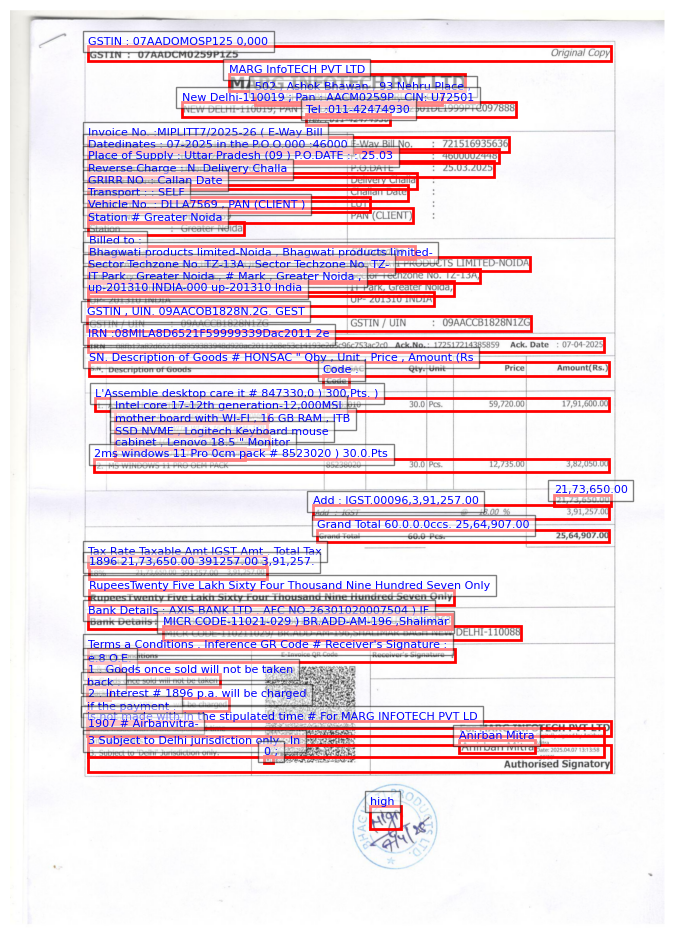

Document best classified as Finance and Banking Categories
[OK] Indexed id=BPL-Receiving 117


BPL-Receiving 107 Document seems to be a pdf of image
Processing Page 1...


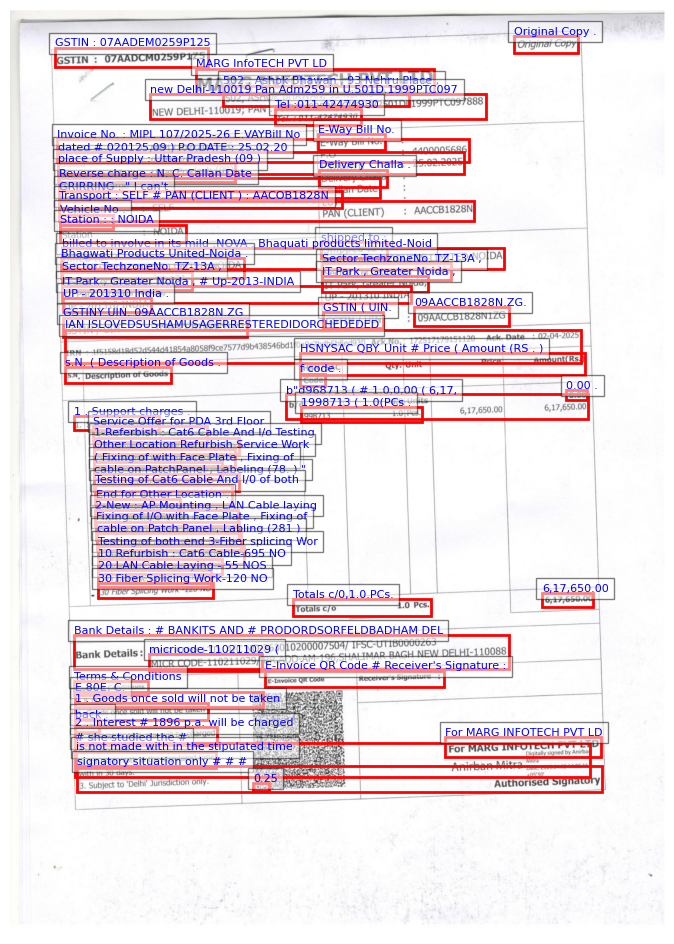

Processing Page 2...


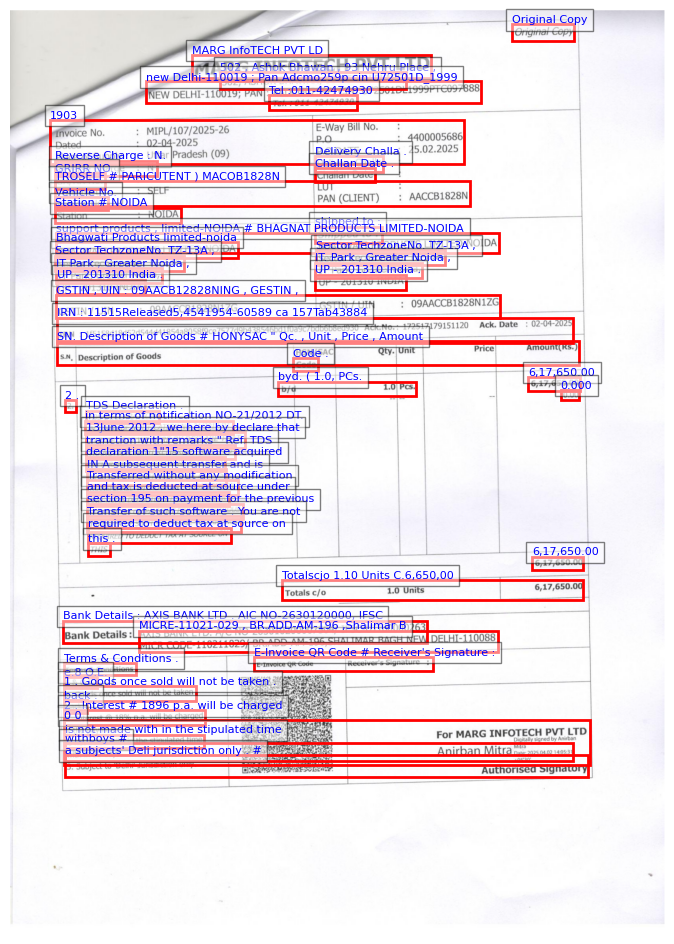

Processing Page 3...


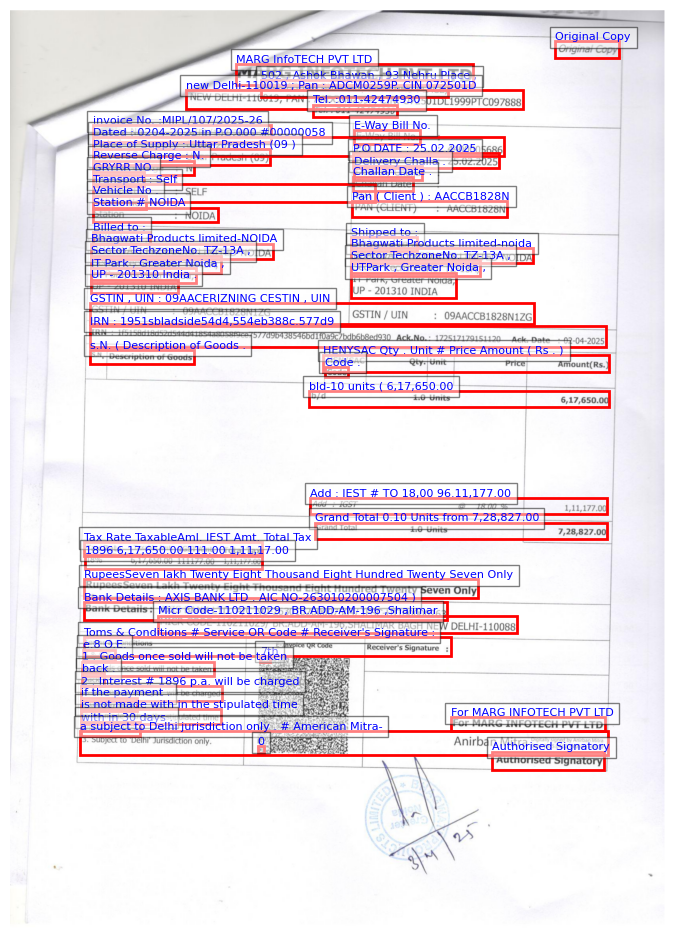

Document best classified as Finance and Banking Categories
[OK] Indexed id=BPL-Receiving 107


SupplyOutward-MIPL-103-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-103-2025-26


SupplyOutward-MIPL-102-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-102-2025-26


BPL-Receiving 113 Document seems to be a pdf of image
Processing Page 1...


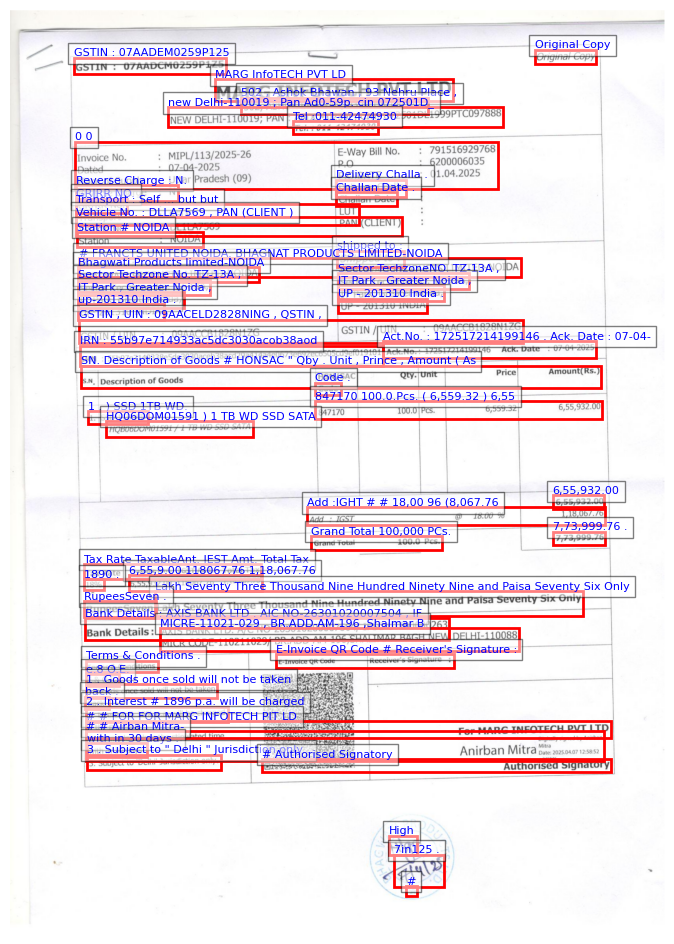

Document best classified as Finance and Banking Categories
[OK] Indexed id=BPL-Receiving 113


SupplyOutward-MIPL-104-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-104-2025-26


BPL-Receiving 118 Document seems to be a pdf of image
Processing Page 1...


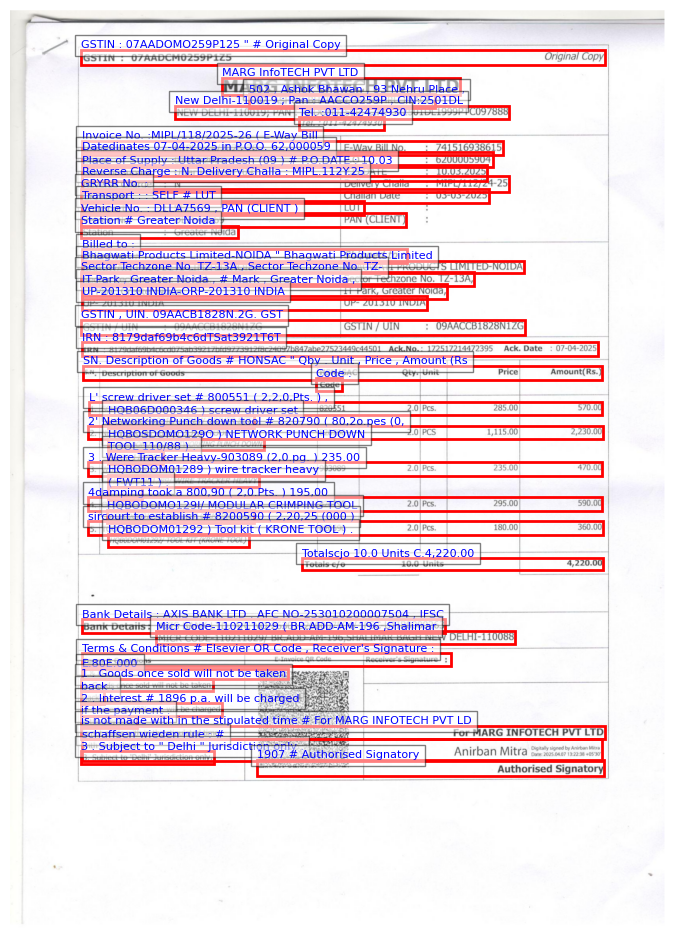

Processing Page 2...


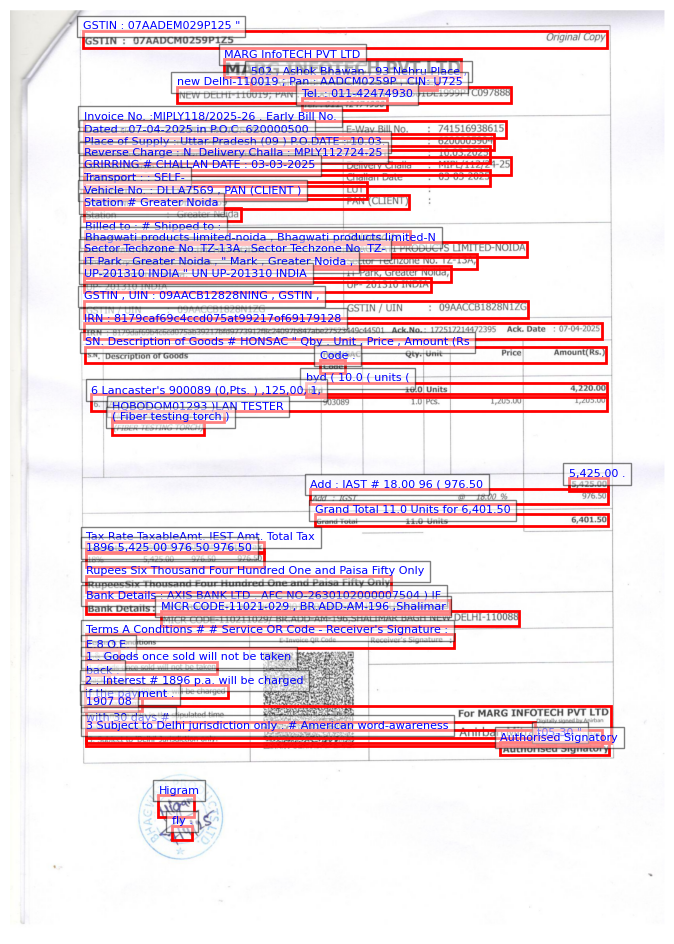

Document best classified as Finance and Banking Categories
[OK] Indexed id=BPL-Receiving 118


BPL-Receiving 115 Document seems to be a pdf of image
Processing Page 1...


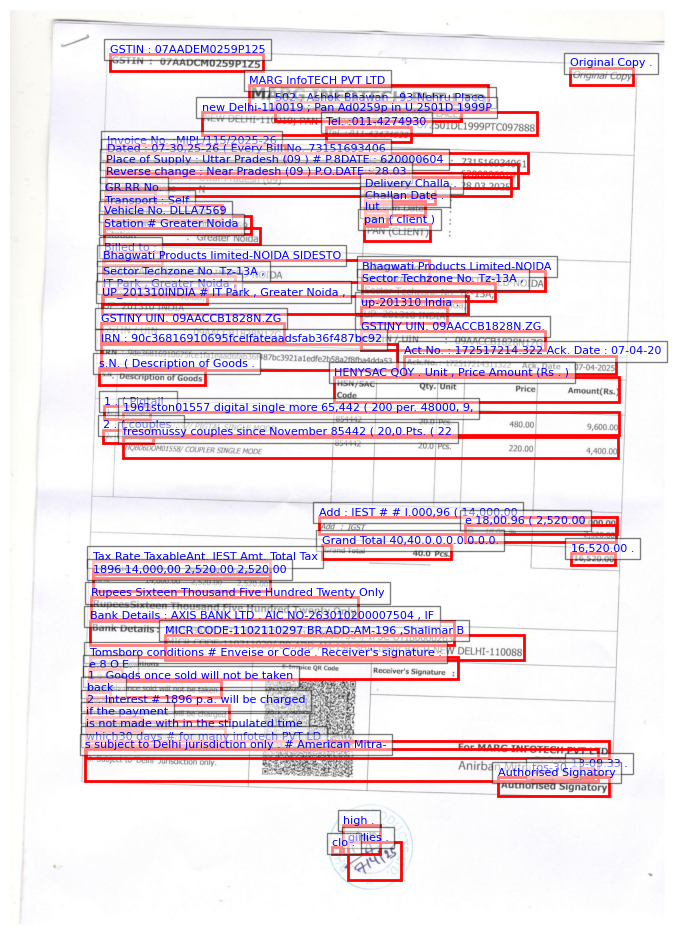

Document best classified as Finance and Banking Categories
[OK] Indexed id=BPL-Receiving 115


SupplyOutward-MIPL-108-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-108-2025-26


SupplyOutward-MIPL-105-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-105-2025-26


SupplyOutward-MIPL-101-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-101-2025-26


SupplyOutward-MIPL-100-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-100-2025-26


BPL-Receiving 116 Document seems to be a pdf of image
Processing Page 1...


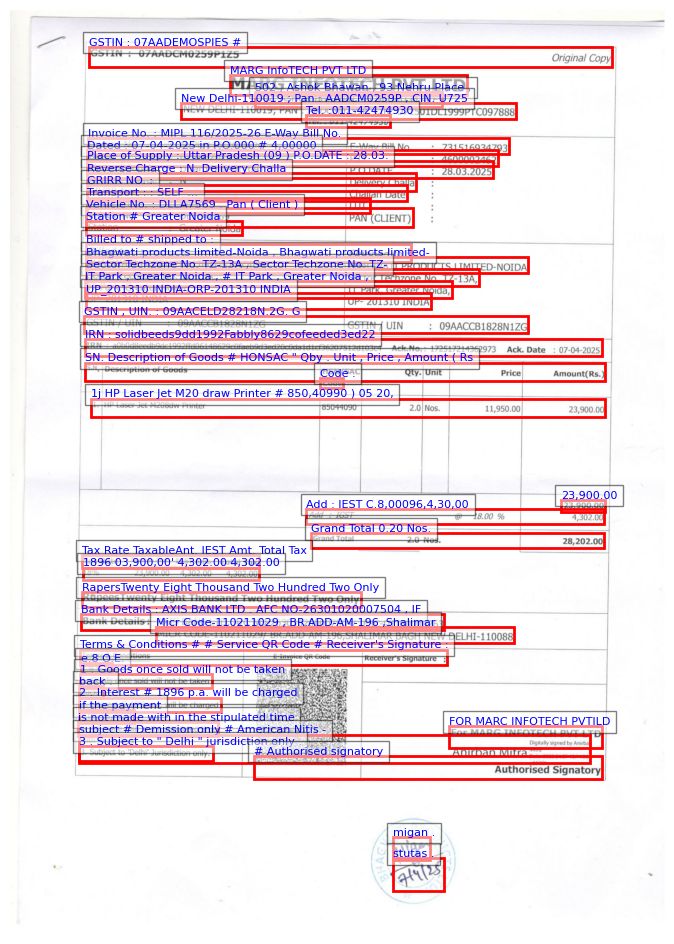

Document best classified as Finance and Banking Categories
[OK] Indexed id=BPL-Receiving 116


SupplyOutward-MIPL-106-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-106-2025-26


SupplyOutward-MIPL-109-2025-26 Document is pdf of text
Document best classified as Finance and Banking Categories
[OK] Indexed id=SupplyOutward-MIPL-109-2025-26


BPL-Receiving 109 Document seems to be a pdf of image
Processing Page 1...


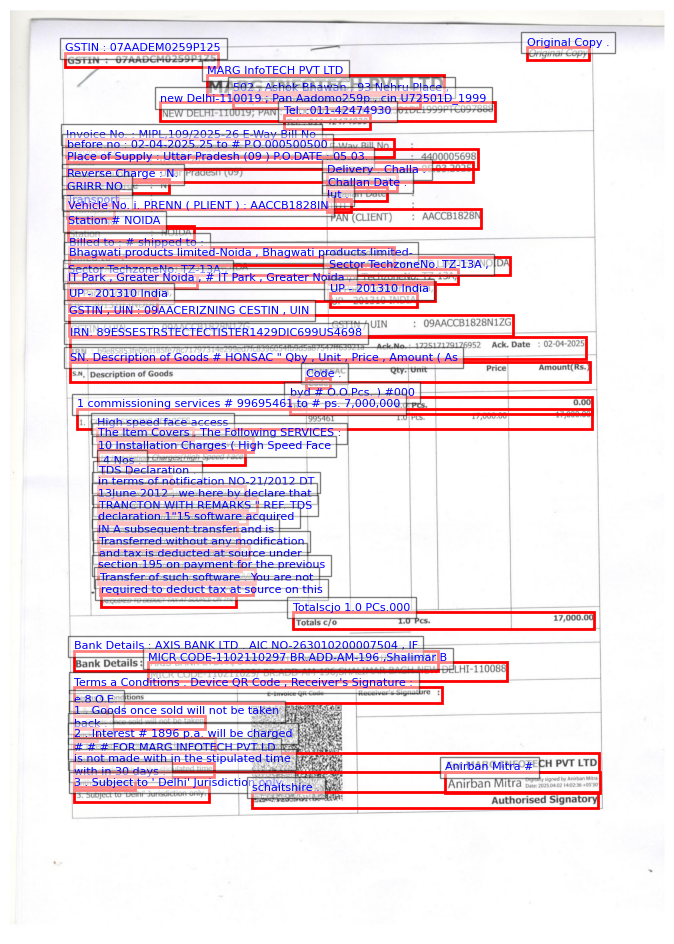

Processing Page 2...


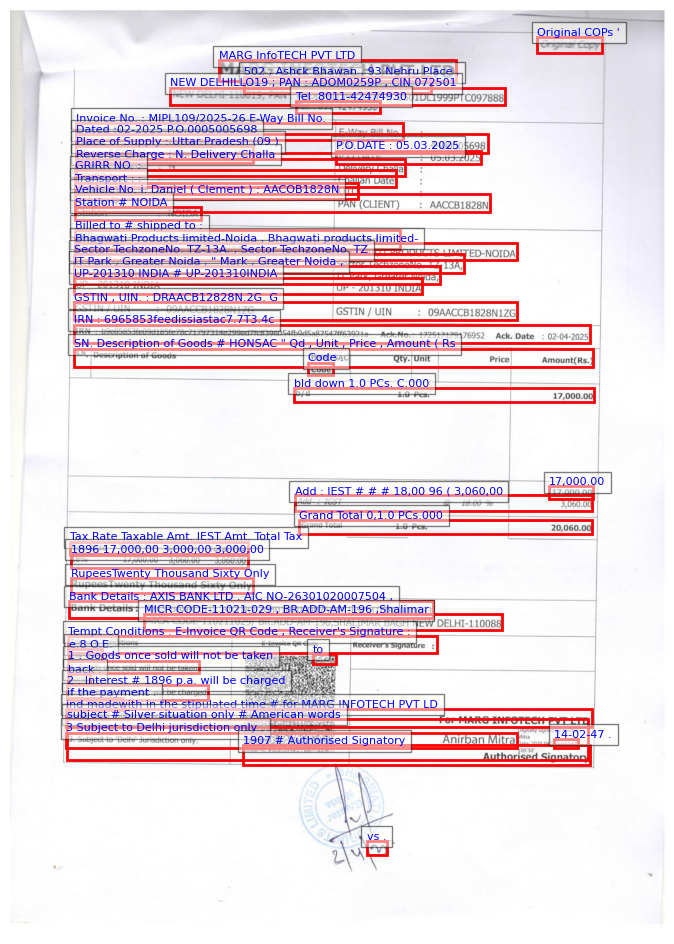

Document best classified as Finance and Banking Categories
[OK] Indexed id=BPL-Receiving 109


BPL-Receiving 114 Document seems to be a pdf of image
Processing Page 1...


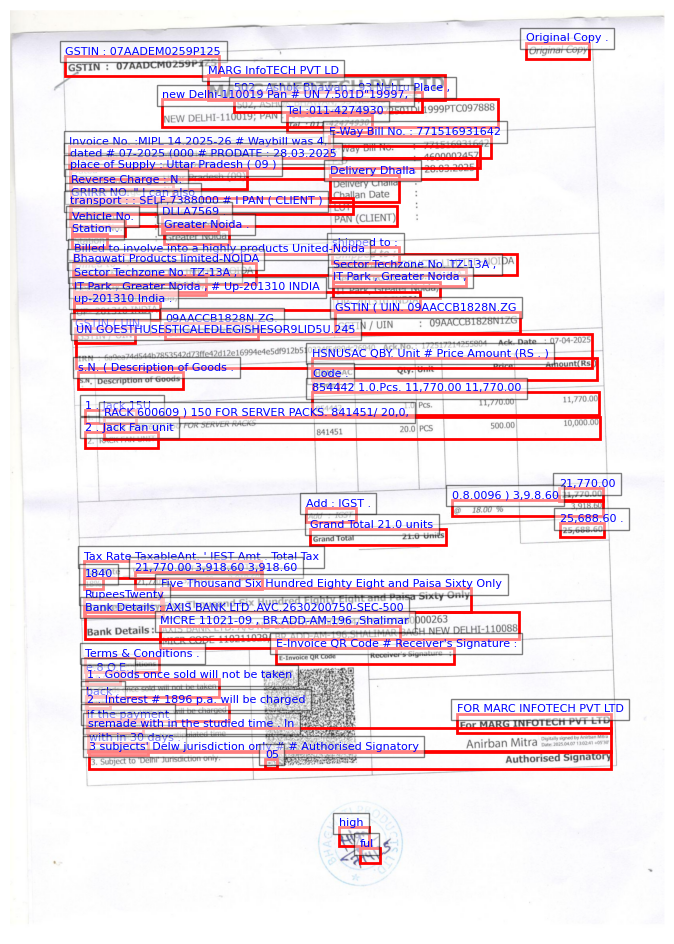

Document best classified as Finance and Banking Categories
[OK] Indexed id=BPL-Receiving 114




In [10]:
def main(folder_path="/home/pa2/Downloads/Marg Invoices/(8-4-2025)/"):
    paths=os.listdir(folder_path)
    for path in paths:
        if not path.lower().endswith(".pdf"):
            continue 
        name=path.split("\\")[-1].split('.')[0]
        os.makedirs("/home/pa2/ml/tf_gpu/OCR/D:/BPL/BLS/Result/", exist_ok=True)
        output_json=f"/home/pa2/ml/tf_gpu/OCR/D:/BPL/BLS/Result/{name}.json"
        ppath=os.path.join(folder_path,path)
        # print(classify_and_extract_pdf(ppath))
        text1=""
        results=[]
        
        text1+=name;
        text1+=" "
        out=classify_and_extract_pdf(ppath)
        # print(out)
        if(out==0):
            print(f"{name} Document seems to be a pdf of image")
            text1=process_pdf(ppath,trocr_model,detector)
        else:
            print(f"{name} Document is pdf of text")
            text1=out
        class1,docs1,doc1=classification(text1,emb_dict,name)
        print("Document best classified as",class1)
        # print(text1)
        # break
        result = {
            "id":name,
            "class": class1,
            "text": text1, 
            "section_embedding": docs1, 
            "total_embedding": doc1.tolist() if hasattr(doc1, "tolist") else doc1 
        }
        send_result_to_solr(result)
        print()
        print()

main("/home/pa2/ml/tf_gpu/OCR/D:/BPL/BLS/DownloadDoc/")

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500,
        chunk_overlap=0
    )

In [12]:
def embedding_conversion(li,embedding_dim=1024):
    flat_embedding=li
    if len(flat_embedding) % embedding_dim != 0:
        raise ValueError("Flat embedding length is not divisible by embedding dimension.")
    
    num_vectors = len(flat_embedding) // embedding_dim
    section_embedding_2d = [
        flat_embedding[i * embedding_dim: (i + 1) * embedding_dim]
        for i in range(num_vectors)
    ]
    return section_embedding_2d

In [11]:
# below cell is to get data from solar

In [13]:
core_name = "mycore"
solr_url = f"http://localhost:8983/solr/{core_name}/select"
initial_params = {
    "q": "*:*",
    "wt": "json",
    "rows": 0
}
response = requests.get(solr_url, params=initial_params)
total_docs = response.json()["response"]["numFound"]
params = {
    "q": "*:*",
    "wt": "json",
    "rows": total_docs
}
response = requests.get(solr_url, params=params)
docs = response.json()["response"]["docs"]
dic={}
docs1=docs
for i in range(len(docs)):
    li=[docs[i]['class'][0],docs[i]['text'][0],embedding_conversion(docs[i]["section_embedding"]),docs[i]['total_embedding']]
    dic[i]=li

In [14]:
import faiss
from sklearn.metrics.pairwise import euclidean_distances,cosine_similarity
model=HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
)
def context_provider(dic,query):
    idx=''
    query=model.embed_query(query)
    query_emb=np.array([query],dtype='float32')
    sim=0
    for i in dic:
        tot_emb=np.array([dic[i][-1]])

        cos_sim = cosine_similarity(query_emb, tot_emb)
        print(cos_sim)
        if(cos_sim>sim):
            sim=cos_sim
            idx=i
    text,sec_emb=dic[idx][1],np.array(dic[idx][2],dtype='float32')
    faiss.normalize_L2(sec_emb)
    db = faiss.IndexFlatIP(sec_emb.shape[1])
    db.add(sec_emb)
    D, I = db.search(query_emb, k=8)
    context=""
    text_split=text_splitter.split_text(text)
    # print(I)
    for i in I[0]:
        context+=text_split[i]
        context+='\n'
    return context

In [19]:
query=input("What is your question:: ")
print(context_provider(dic,query))

What is your question::  what was reason for conflict between state and surendrasingh


[[0.73073701]]
[[0.72662516]]
[[0.82558457]]
the case rests on circumstantial evidence has no role to play. It was observed in paragraph 40 as
under:-
Anil Surendrasingh Yadav vs State Of Gujarat on 27 December, 2019
Indian Kanoon - http://indiankanoon.org/doc/137212109/
25
Indian Kanoon - http://indiankanoon.org/doc/137212109/
9
--- Page 1 ---
Anil Surendrasingh Yadav vs State Of Gujarat on 27 December,
2019
Equivalent citations: AIRONLINE 2019 GUJ 853
Author: Bela M. Trivedi
Bench: Bela M. Trivedi, A.C. Rao
       R/CR.A/1973/2019                                        CAV JUDGMENT
            IN THE HIGH COURT OF GUJARAT AT AHMEDABAD
                     R/CRIMINAL APPEAL NO. 1973 of 2019
                                With
              R/CRIMINAL CONFIRMATION CASE NO. 2 of 2019
FOR APPROVAL AND SIGNATURE:
HONOURABLE MS.JUSTICE BELA M. TRIVEDI                           Sd/-
and
HONOURABLE MR.JUSTICE A.C. RAO                                  Sd/-
1     Whether Reporters of Local Pa